In [1]:
import numpy as np
import rebound
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, root, least_squares
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import CubicSpline
import os, sys
import gc
import pandas as pd

from importlib import reload
import integrator
reload(integrator)
from integrator import *

In [2]:
default_configs = {
    'planet_num': 2,
    'planet_mass': [1e-7, 1e-7],
    'kappa': 2,
    'inner_period': 2*np.pi,
    'C': [],
    'target_mean_anomaly': 4*np.pi,
    'init_time_step': 0.2,
    'bisection_tol': 1e-13,
    'bisection_doom': 50000,
}

In [3]:
# Continuation

# Different solution.

mass_cands = 10 ** np.arange(-9., -4., 1.)
# mass_cands = [1e-7]

init_theta = [-1, -1, np.pi, 0]
bounds = [(-3, -0.5), (-3, -0.5), (-2*np.pi, 2*np.pi), (-2*np.pi, 2*np.pi)]

for i, m in enumerate(mass_cands):
    m_configs = default_configs.copy()
    m_configs['planet_mass'] = [m, m]
    m_configs['kappa'] = 2

    res_0 = minimize(optimizing_function, x0=init_theta, method='Nelder-Mead', bounds=bounds, args=(m_configs,), options={ 'xatol':1e-14, 'fatol':1e-14})
    print(f'Masses {i}, first done!')
    res = minimize(optimizing_function, x0=res_0.x, method='L-BFGS-B', args=(m_configs,), bounds=bounds, tol=1e-14)
    print(f'Masses {i}, second done!')
    init_theta = res.x
    print(res.x, res.fun)

mse = calculate_mse(res.x, m_configs)
print(res.x, res.fun, mse)
print(m_configs)
    

/Users/chatszet/Documents/My Projects/PythonProjects/rebound_demo/exobound/integrator.py:83: UserWarning: Bisection doom count reached!
  warnings.warn("Bisection doom count reached!")


Masses 0, first done!
Masses 0, second done!
[-5.44271315e-01 -1.19852931e+00  3.08682359e+00  1.02493314e-03] 6.23902602349565e-18
Masses 1, first done!
Masses 1, second done!
[-5.61442331e-01 -1.19660810e+00  3.07972709e+00  1.03131433e-03] 1.0692768391791903e-15
Masses 2, first done!
Masses 2, second done!
[-0.68879347 -1.4556495   3.14158965  0.00326101] 4.086544109478958e-16
Masses 3, first done!
Masses 3, second done!
[-6.88793577e-01 -1.45564926e+00  3.14159262e+00  1.41735549e-03] 8.302961891775229e-15
Masses 4, first done!
Masses 4, second done!
[-6.88708909e-01 -1.45576058e+00  3.14159103e+00  1.23263584e-03] 1.3238184224820774e-12
[-6.88708909e-01 -1.45576058e+00  3.14159103e+00  1.23263584e-03] 1.3238184224820774e-12 3.860840973564725e-12
{'planet_num': 2, 'planet_mass': [np.float64(1e-05), np.float64(1e-05)], 'kappa': 2, 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.2, 'bisection_tol': 1e-13, 'bisection_doom': 50

12.565984768635905
-0.002622301398604986


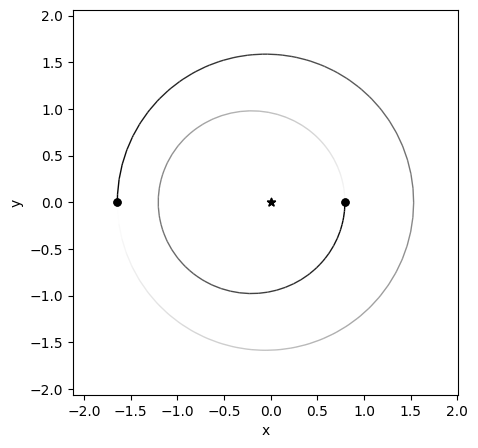

In [4]:

sim = init_simulation(res.x, m_configs)
_, target_time, times, M = integrate_one_cycle(sim, m_configs)
print(target_time)
sim.integrate(target_time*10)
print(sim.particles[1].pomega)
rebound.OrbitPlot(sim)


In [5]:
marks = np.arange(0, 5001, 1)

print(target_time)
print(m_configs)

sim = init_simulation(res.x, m_configs)
_, target_time, _, _ = integrate_one_cycle(sim, m_configs)

angle_hist = np.zeros(len(marks))
pomega_1_hist = np.zeros(len(marks))
pomega_2_hist = np.zeros(len(marks))


for i, m in enumerate(marks):
    sim.integrate(sim.t + target_time)
    sim.t = 0
    sim.move_to_hel()
    
    angle_hist[i] = sim.particles[1].l - 2*sim.particles[2].l + sim.particles[1].pomega

    pomega_1_hist[i] = sim.particles[1].pomega
    pomega_2_hist[i] = sim.particles[2].pomega

    # print(sim.particles[1].l, sim.particles[2].l, sim.particles[1].pomega)

12.565984768635905
{'planet_num': 2, 'planet_mass': [np.float64(1e-05), np.float64(1e-05)], 'kappa': 2, 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.2, 'bisection_tol': 1e-13, 'bisection_doom': 50000}


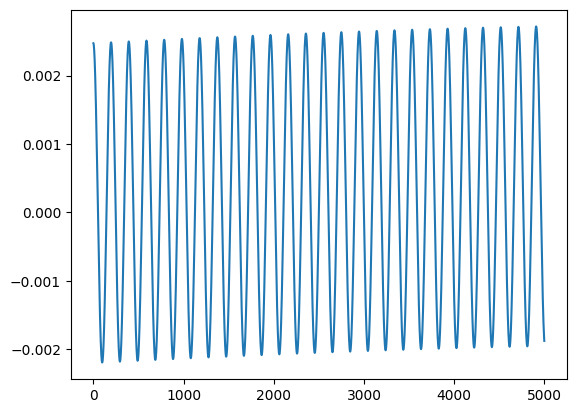

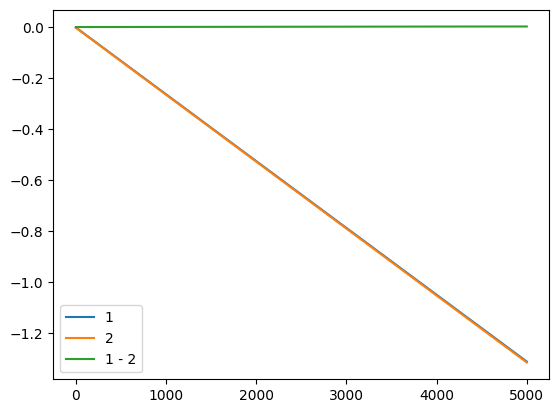

In [6]:
plt.plot(wrap_angles(angle_hist))
plt.show()

plt.plot(wrap_angles(pomega_1_hist), label='1')
plt.plot(wrap_angles(pomega_2_hist), label='2')
plt.plot(wrap_angles(pomega_1_hist - pomega_2_hist), label='1 - 2')
plt.legend()
plt.show()
